In [1]:
import pandas as pd
from cif import cif
import math
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import cvxpy as cvx

## Pays et variables

In [2]:
pays_ocde = {"Australia" :'AUS',"Austria":'AUT',"Belgium":'BEL',"Canada":'CAN',"Denmark":'DNK', "Germany" :'DEU', "Spain":'ESP',
             "Finland":'FIN',"France":'FRA',"Hungary":'HUN',"Ireland":'IRL', "Iceland": 'ISL', "Italy":'ITA', 'Korea': 'KOR',
             "Japan":'JPN',"Luxembourg":'LUX',"Norway":'NOR',"New-Zealand":'NZL',"Netherlands":'NLD',"Portugal":'PRT',
             "United Kingdom":'GBR',"Sweden":'SWE',"Switzerland":'CHE',"Slovak Republic":'SVK',"United-States":'USA'}

variables = ['Actifs', 'Chomage', 'Conso', 'Emplois', 'Exports', 'Formation', 'PIB']

In [3]:
#On importe les données
data = pd.read_csv(r'df_countries.csv', header=[0,1])
#On trie les données pour améliorer les performances et éviter les warnings:
data = data.sort_index(axis=1)
data

Australia                                                      \
           Actifs   Chomage    Conso       Emplois  Exports Formation   
0     8370.376197  6.230017  108.373   7848.887183   26.942    41.272   
1     8433.822366  6.464528  108.965   7888.576199   26.986    39.657   
2     8483.398742  7.225374  109.106   7870.456547   28.052    39.505   
3     8485.045602  7.867509  108.421   7817.473423   28.496    38.098   
4     8475.589675  8.732559  108.655   7735.432101   29.718    36.525   
..            ...       ...      ...           ...      ...       ...   
115  13367.835677  5.036932  269.237  12694.503323  116.289   113.421   
116  13438.648863  5.025599  270.344  12763.267120  117.730   112.908   
117  13548.015373  5.229841  271.263  12839.473383  119.828   111.780   
118  13627.495013  5.229903  271.271  12914.793160  121.027   112.796   
119  13648.438717  5.163222  272.137  12943.751490  120.003   111.846   

                  Austria                       ... United Kingdom            \
         PIB       Actifs   Chomage      Conso  ...        Exports Formation   
0    206.890  3502.507749  3.153923        NaN  ...         57.775    65.832   
1    207.173  3506.547721  3.269969        NaN  ...         57.660    64.894   
2    205.931  3536.177875  3.412282        NaN  ...         57.587    64.302   
3    207.139  3565.814571  3.239165        NaN  ...         58.048    63.582   
4    204.453  3587.854409  3.383817        NaN  ...         55.892    60.688   
..       ...          ...       ...        ...  ...            ...       ...   
115  486.434  4555.836726  4.773069  47.426269  ...        166.762    95.337   
116  488.794  4570.020916  4.764791  48.142092  ...        164.775    97.322   
117  491.972  4551.411567  4.470553  47.896378  ...        163.512    96.280   
118  494.933  4550.020453  4.378128  47.714164  ...        172.158    97.537   
119  497.109  4566.247064  4.331108  47.539347  ...        178.741    95.955   

              United-States                                                \
         PIB         Actifs   Chomage      Conso        Emplois   Exports   
0    305.893  125781.333333  5.300000   5998.058  119114.333333   682.300   
1    307.471  125705.000000  5.333333   6016.329  118995.333333   690.785   
2    304.257  125871.333333  5.700000   6040.163  118712.000000   696.014   
3    303.210  126069.000000  6.133333   5994.212  118361.000000   702.143   
4    302.325  126071.000000  6.600000   5971.672  117782.333333   706.434   
..       ...            ...       ...        ...            ...       ...   
115  538.222  162769.333333  3.833333  13033.382  156549.666667  2548.787   
116  541.195  163036.333333  3.866667  13093.153  156779.333333  2560.413   
117  541.944  162877.000000  3.666667  13212.778  156918.333333  2531.422   
118  544.639  163801.666667  3.600000  13301.349  157902.666667  2536.562   
119  544.733  164434.666667  3.600000  13353.687  158543.666667  2557.846   

                          
    Formation        PIB  
0    1695.374   9358.289  
1    1668.437   9392.251  
2    1659.143   9398.499  
3    1628.395   9312.937  
4    1587.408   9269.367  
..        ...        ...  
115  3983.118  18813.923  
116  4020.353  18950.347  
117  4029.714  19020.599  
118  4054.506  19141.744  
119  4075.404  19253.959  

[120 rows x 176 columns]

## Test de stationnarité

In [4]:
from statsmodels.tsa.stattools import kpss
# On définit les deux tests qu'on souhaite réaliser
np.set_printoptions(suppress=True)
#KPSS
def kpss_test(series, **kw):    
    return(kpss(series, **kw)[1])

# Test de la série intégrée à l'ordre 1
def kpss_test_int(serie1):
    serie2 = serie1 - serie1.shift().fillna(0)
    return(kpss_test(serie2))

# ADF

from statsmodels.tsa.stattools import adfuller

def adf_test(series, **kw):    
    return(round(adfuller(series, **kw)[1], 3))

def adf_test_int(serie1):
    serie2 = serie1 - serie1.shift().fillna(0)
    serie2.dropna(inplace=True)
    adf_test(serie2)
    return(round(adf_test(serie2), 3))

In [5]:
# Exemple avec la série temporelle du PIB des USA

serie1 = data['United-States']['PIB']
print('P-value pour le test KPSS de la série brute:', kpss_test(serie1))
print('P-value pour le test KPSS de la série intégrée à l ordre 1:', kpss_test_int(serie1))
print('P-value pour le test ADF de la série brute:', adf_test(serie1))
print('P-value pour le test ADF de la série intégrée à l ordre 1:', adf_test_int(serie1))

P-value pour le test KPSS de la série brute: 0.01
P-value pour le test KPSS de la série intégrée à l ordre 1: 0.1
P-value pour le test ADF de la série brute: 0.956
P-value pour le test ADF de la série intégrée à l ordre 1: 0.0


C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


In [6]:
pays = []
for x in pays_ocde.keys():
    pays.append(x)
len(pays)

25

In [7]:
# On crée le tableau où on l'a va repertorier les p-values

tabkpss=pd.DataFrame(index= variables, columns=pays)
tabkpss

,Australia,Austria,Belgium,Canada,Denmark,Germany,Spain,Finland,France,Hungary,...,Luxembourg,Norway,New-Zealand,Netherlands,Portugal,United Kingdom,Sweden,Switzerland,Slovak Republic,United-States
Actifs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Chomage,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Conso,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Emplois,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Exports,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Formation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PIB,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [8]:
# On remplit le tableau avec les p-values des tests de stationnarité KPSS

for a in pays_ocde.keys(): 
    for b in variables: 
        serie1=data[a][b]
        g=kpss_test(serie1)
        #print(g)
        if g > 0.05:
            tabkpss[a][b]=kpss_test(serie1)
        else :
            tabkpss[a][b]=kpss_test_int(serie1)
tabkpss

C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1661: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: Interpolatio

C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-va

C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1685: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)
C:\Users\adxva\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:1687: InterpolationWarning: p-va

,Australia,Austria,Belgium,Canada,Denmark,Germany,Spain,Finland,France,Hungary,...,Luxembourg,Norway,New-Zealand,Netherlands,Portugal,United Kingdom,Sweden,Switzerland,Slovak Republic,United-States
Actifs,0.1,0.1,NaN,0.1,0.0661947,0.1,NaN,NaN,NaN,NaN,...,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,0.1
Chomage,0.1,0.1,NaN,0.1,0.1,0.0512185,NaN,NaN,NaN,NaN,...,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,0.1
Conso,0.1,NaN,NaN,0.1,NaN,NaN,NaN,0.1,0.1,NaN,...,NaN,0.1,0.1,NaN,NaN,NaN,NaN,0.1,NaN,0.1
Emplois,0.1,0.1,NaN,0.1,0.0697,0.1,NaN,NaN,NaN,NaN,...,NaN,NaN,0.1,NaN,NaN,NaN,NaN,NaN,NaN,0.1
Exports,0.1,NaN,NaN,0.0526329,NaN,NaN,NaN,0.1,0.1,NaN,...,NaN,0.0480613,0.099085,NaN,NaN,0.1,NaN,0.1,NaN,0.1
Formation,0.1,NaN,NaN,0.1,NaN,NaN,NaN,0.1,0.1,NaN,...,NaN,0.1,0.1,NaN,NaN,0.1,NaN,0.1,NaN,0.1
PIB,0.1,NaN,NaN,0.1,NaN,NaN,NaN,0.0921927,0.1,NaN,...,NaN,0.0813775,0.1,NaN,NaN,0.0982047,NaN,0.1,NaN,0.1


In [9]:
# On fait de même pour les tests ADF

tabadf = pd.DataFrame(index= variables, columns=pays)

for a in pays_ocde.keys(): 
    for b in variables: 
        serie1=data[a][b]
        serie1.dropna(inplace=True)
        #print(serie1)
        g=adf_test(serie1)
        #print(g)
        if g > 0.05:
            tabadf[a][b]=adf_test(serie1)
        else :
            tabadf[a][b]=adf_test_int(serie1)
tabadf

C:\Users\adxva\anaconda3\lib\site-packages\pandas\core\series.py:4494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(result)


,Australia,Austria,Belgium,Canada,Denmark,Germany,Spain,Finland,France,Hungary,...,Luxembourg,Norway,New-Zealand,Netherlands,Portugal,United Kingdom,Sweden,Switzerland,Slovak Republic,United-States
Actifs,1,0.846,0.899,0.988,0.869,0.993,0.102,0.543,0.687,0.995,...,0.999,0.934,0.999,0.482,0.29,0.957,0.996,0,0,0.666
Chomage,0.594,0.156,0.143,0.579,0.486,0.868,0.609,0,0.359,0.517,...,0.151,0.09,0.082,0.146,0.351,0.75,0.058,0.167,0.502,0.186
Conso,0.942,0.514,0.983,0.998,0.906,0.987,0.321,0.968,0.93,0.737,...,0.989,0.977,0.998,0.141,0.238,0.284,0.992,0.997,0.9,0.881
Emplois,0.998,0.926,0.951,0.986,0.728,0.999,0.274,0.374,0.949,0.733,...,0.999,0.875,0.982,0.539,0.289,0.993,0.996,0,0.877,0.795
Exports,0.998,0.826,0.828,0.311,0.884,0.944,0.835,0.669,0.867,0.968,...,0.923,0.057,0.911,0.979,0.996,0.94,0.698,0.993,0.98,0.908
Formation,0.854,0.963,0.927,0.801,0.606,0.955,0.209,0.931,0.931,0.887,...,0.725,0.849,0.988,0.298,0.3,0.965,0.867,0.996,0.505,0.857
PIB,0.999,0.692,0.786,0.965,0.956,0.93,0.514,0.918,0.834,0.977,...,0.891,0.291,0.994,0.63,0.299,0.829,0.894,0.997,0.96,0.956


# Méthode à contrôle synthétique

On créé le dataframe qui nous intéresse qui est de la forme : pays en colonnes, année + variable en ligne (une ligne est donc la valeur d'une variable, pour une année donnée dans chaque pays)


In [10]:
df_ct = pd.DataFrame()
for i in variables :
    interm = data.xs(str(i), axis=1, level=1, drop_level=True)   #On prend uniquement les colonnes qui se rapporte à une variable avec .xs
    interm = interm.drop(0, axis=0)                                #On enlève la ligne d'indice 0 qui est vide (seulement des nan)
    interm['Variables'] = str(i)                                    #on rajoute une colonne "variables" qui nous servira plus tard pour construire le problème d'optimisation
    df_ct = pd.concat([df_ct, interm], axis=0)                      #On concatène le df ainsi créé avec les autres


df_ct.rename(columns=pays_ocde, inplace=True)
df_ct.drop(list(d for d in range(1, 20)), inplace=True) # On commence en 1995

df_ct2 = df_ct[df_ct["Variables"].isin(['PIB', 'Actifs', 'Emplois'])].dropna()


In [11]:
# Nous créons aussi un df pour calculer les moyennes agrégées requises

data_mean = data.copy()
for pays in pays_ocde.keys():
    data_mean[pays] = data_mean[pays].assign(Conso=lambda x: x.Conso / x.PIB)

data_mean.rename(columns={'Conso': 'Conso_share'}, inplace=True)

for pays in pays_ocde.keys():
    data_mean[pays] = data_mean[pays].assign(Emplois=lambda x: np.log(x.PIB/x.Emplois) - np.log(x.PIB.shift()/x.Emplois.shift()))

data_mean.rename(columns={'Emplois': 'Prod_growth'}, inplace=True)

for i in pays_ocde.keys() :
    data_mean=data_mean.drop([(i,'PIB'),(i,'Actifs')], axis=1)
    
df_ct_mean = pd.DataFrame()
for i in ['Chomage', 'Conso_share', 'Prod_growth','Exports', 'Formation']:
    interm = data_mean.xs(str(i), axis=1, level=1, drop_level=True)   #On prend uniquement les colonnes qui se rapporte à une variable avec .xs
    interm = interm.drop(0, axis=0)                                #On enlève la ligne d'indice 0 qui est vide (seulement des nan)
    interm['Variables'] = str(i)                                    #on rajoute une colonne "variables" qui nous servira plus tard pour construire le problème d'optimisation
    df_ct_mean = pd.concat([df_ct_mean, interm], axis=0)

df_ct_mean.rename(columns=pays_ocde, inplace=True)

In [12]:
# On mesure le PIB en déviation par rapport à l'année 1995
for var in ['PIB', 'Actifs', 'Emplois']:    
    for pays in df_ct2.drop('Variables', 1).columns:    
        df_ct2[df_ct2["Variables"]==var] = df_ct2[df_ct2["Variables"]==var].assign(**{pays: lambda x: (x[pays] - x[pays].iloc[0]) / x[pays].iloc[0]})

## Modélisation

In [13]:
# Modélisation avec la moyenne sur la période pré-intervention
# On crée nos deux vecteurs: X1, la matrice du pays traité, X0, la matrice du donor pool

np.set_printoptions(suppress=True) # Pour éviter les notations avec exponentielles

X1 = df_ct2[['USA', 'Variables']]
X1 = X1.drop(list(d for d in range(109,120)))
X1_mean = df_ct_mean[['USA', 'Variables']].groupby('Variables').mean().reset_index()
X1 = pd.concat([X1, X1_mean]).reset_index().drop(['index', 'Variables'], 1)
X1 = X1.values


X0 = df_ct2.drop('USA', 1)
X0 = X0.drop(list(d for d in range(109,120)))
X0_mean = df_ct_mean.drop('USA', 1).groupby('Variables').mean().reset_index()
X0 = pd.concat([X0, X0_mean]).reset_index().drop(['index', 'Variables'], 1)
X0 = X0.values

In [14]:
# On construit et on "résout" le problème cvxpy

x = cvx.Variable((24,1),nonneg=True)                #On définit un vecteur de variables cvxpy
cost = cvx.norm(X1 - X0@x, p=2)                     #on définit la fonction de cout : norme des résidus
constraints = [x>=0, cvx.sum(x)==1]                     #La contrainte
prob = cvx.Problem(cvx.Minimize(cost), constraints)  #On définit le problème
prob.solve()                                        #On le résout


0.23111905754892262

In [15]:
#Print result

print("\nThe optimal value is", prob.value)
print("The optimal x is")
print(x.value)
print("The norm of the residual is ", cvx.norm(X0@x - X1, p=2).value)


The optimal value is 0.23111905754892262
The optimal x is
[[0.09707962]
 [0.00000001]
 [0.        ]
 [0.00000001]
 [0.12906437]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.13464857]
 [0.07260532]
 [0.        ]
 [0.07742117]
 [0.00132425]
 [0.        ]
 [0.04984821]
 [0.00000001]
 [0.        ]
 [0.04839819]
 [0.00000001]
 [0.        ]
 [0.        ]
 [0.        ]
 [0.38961024]]
The norm of the residual is  0.23111906426703835


## Visualisation

In [16]:
# Table des coefficients associés à chaque pays du donor pool

pd.set_option('display.float_format', lambda x: '%.3f' % x) #pour avoir des résultats lisibles


country_list = df_ct.dropna().drop(['USA', 'Variables'], axis=1)
coeff = pd.DataFrame(x.value, index=country_list.columns)
coeff

,0
AUS,0.097
AUT,0.000
BEL,0.000
CAN,0.000
DNK,0.129
FIN,0.000
FRA,0.000
DEU,0.000
HUN,0.000
ISL,0.135


### Comparaison des pondérations trouvées avec celle de l'article de Born et al. [2020]


|Pays   | Nous  |Article|
|---    |:-:    |:-:    |
|   UK  | 0.390 |  0.29 |
|  POR  | 0.048 |  0.18 |
|  NLD  | 0.050 | <0.01 |
|  JPN  | 0.077 |  0.13 |
|  IRL  | 0.073 |  0.11 |
|  ISL  | 0.135 | <0.01 |
|  DNK  | 0.129 | <0.01 |
|  AUS  | 0.097 | <0.01 |
|  NZL  | <0.01 |  0.09 |
|  KOR  | <0.01 |  0.10 |
|  NOR  | <0.01 |  0.07 |
|  SVK  | <0.01 |  0.03 |

In [17]:
# Graphique du PIB des USA et du contrôle synthétique

# On définit la table qui va nous servir pour créer le graphique

df_pib = df_ct2[df_ct2["Variables"]=="PIB"]
df_pib.drop(df_pib.columns.difference(['USA', 'GBR', 'AUS', 'DNK', 'ISL', 'IRL', 'JPN', 'KOR', 'NLD', 'PRT']), 1, inplace=True)
df_pib.dropna(inplace=True)

# Voici le vecteur pondéré du contrôle synthétique
sc = 0.390*df_pib['GBR'] + 0.077*df_pib.JPN + 0.097*df_pib['AUS'] + 0.129*df_pib.DNK + 0.135*df_pib['ISL'] + 0.073*df_pib.IRL + 0.05*df_pib['NLD'] + 0.048*df_pib.PRT

C:\Users\adxva\anaconda3\lib\site-packages\pandas\core\frame.py:3990: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(
<ipython-input-17-4785d4f7066a>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pib.dropna(inplace=True)


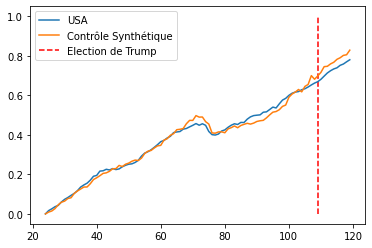

In [18]:
#Graphique

df_pib['USA'].plot(label='USA')
sc.plot(label="Contrôle Synthétique")
plt.vlines(109, 0, 1, linestyle = '--', color = 'red', label = 'Election de Trump')
plt.legend()
plt.show()
#En absisse, l'axe temporelle commence en 1995 (20), l'élection de Trump arrive en 109 et 120 est le Q1 2020.